# Import resources

In [1]:
pip install -U pymoo

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.optimize import minimize
from pymoo.problems import get_problem
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.visualization.scatter import Scatter
from pymoo.algorithms.moo.nsga3 import NSGA3
from pymoo.operators.repair.rounding import RoundingRepair
from pymoo.operators.sampling.rnd import IntegerRandomSampling
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.crossover.pntx import PointCrossover, SinglePointCrossover, TwoPointCrossover

# Preparation Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
def data_top(path, n):
  df_all = pd.read_csv(path)
  df_sorted = df_all.sort_values(by='Liquidity', ascending=False)
  top_rows = df_sorted.head(n)
  return top_rows

In [5]:
def df2nparray(df):
  Symbol = df['Symbol'].to_numpy()
  P = df['Lastest Price'].to_numpy()
  ER = df['Expected Return'].to_numpy()
  R = df['Risk'].to_numpy()
  L = df['Liquidity'].to_numpy()
  return Symbol, P, ER, R, L

# NSGA3

1. Algorithm with reference
2. Problem
3. Execute optimization










## Reference

In [6]:
# Das-Dennis Reference
ref_dirs = get_reference_directions("uniform", 2, n_partitions=12)
# Scatter().add(ref_dirs).show()

## Problem definition (element wise)

In [24]:
from pymoo.core.problem import ElementwiseProblem

class ProblemElement(ElementwiseProblem):
    def __init__(self):
      xl = np.zeros(n_var, dtype=int)
      xu = np.ones(n_var, dtype=int)*99

      super().__init__(n_var = n_var,
                        n_obj = 2,
                        xl = xl,
                        xu = xu,
                        vtype = int,
                        n_ieq_constr = 3,
                       )

    def _evaluate(self, x, out, *args, **kwargs):
        return_objective = -np.sum(x*P*ER*10)  # Negative because pymoo minimizes objectives by default
        risk_objective = np.sum(x*P*10*R)

        # Define the constraints
        budget_constr = np.sum(x*P*10) - 1000000
        risk_constr = np.sum(x*P*R*10) - 1000000*0.3
        diverse_constr = 0 if np.any(x*P*10/1000000) - 0.7 else 1

        # Assign objectives and constraints to the output
        out["F"] = [return_objective, risk_objective]
        out["G"] = [budget_constr, risk_constr, diverse_constr]

problem_e = ProblemElement()

# Main Functions

In [40]:
def main_opt(path, n, budget, params_list):
  df = data_top(path, n)
  global Symbol, P, ER, R, L
  Symbol, P, ER, R, L = df2nparray(df)

  pop_size = params_list[0]
  n_gen = params_list[1]
  x_rate = params_list[2]
  mutate_rate = params_list[3]

  # 1. Algorithm with reference
  algorithm = NSGA3(pop_size = pop_size,
                    ref_dirs = ref_dirs,
                    sampling = IntegerRandomSampling(),
                    crossover = SBX(prob=x_rate, eta=30, vtype=float, repair=RoundingRepair()), #default + repair for integer
                    mutation = PM(prob=mutate_rate, eta=20, vtype=float, repair=RoundingRepair()), #default + repair for integer
                    )

  # 2. Problem
  problem_elem = ProblemElement()

  # 3. Execute optimization
  res = minimize(problem_elem,
                 algorithm,
                 termination = ('n_gen', n_gen),
                 verbose = False,
                 save_history = True,
                 )

  # 4. Results
  optimal_solutions = res.X
  optimal_objectives = res.F
  result_df = pd.DataFrame()
  result_df['Return'] = optimal_objectives[:,0]*-1
  result_df['Risk'] = optimal_objectives[:,1]

  # Plot the Pareto front
  plt.scatter(optimal_objectives[:, 1], optimal_objectives[:, 0]*-1, label="Pareto Front")
  plt.plot([0, 300000], [0, 300000], color='red', linestyle='--', label='Return = Risk')
  plt.xlim(0, 300000)
  plt.ylim(0, 300000)
  plt.xlabel("Risk")
  plt.ylabel("Return")
  plt.legend()
  plt.title("Pareto Front for Portfolio Optimization")
  plt.show()

  return result_df, optimal_solutions

# Run

In [11]:
global budget, n_var
path = '/content/drive/MyDrive/Symbols24.csv'
budget = 1000000

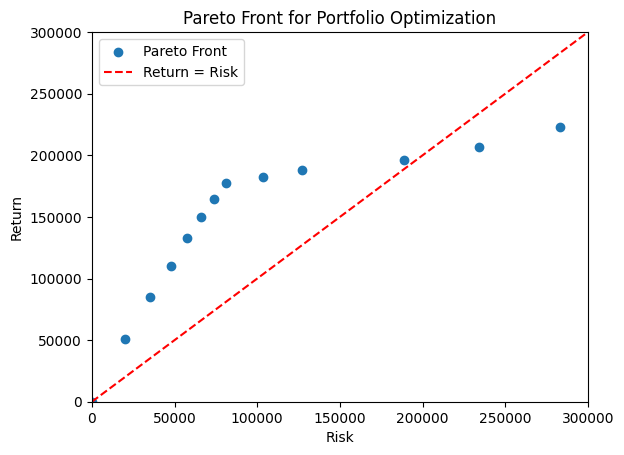

           Return           Risk
0        0.000000       0.000000
1   196114.974464  188578.853346
2   188168.557132  127276.475211
3    84765.304703   35065.386465
4   182580.177995  103698.339403
5   110106.619684   47750.796027
6   223100.156318  282838.260737
7   177468.267008   80949.784769
8   164764.127759   73923.989222
9   132578.554259   57432.611320
10  206644.441906  233977.669949
11  149976.132554   66226.232351
12   50929.660697   19866.662877
[[ 0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0 10  0 33  0  0  0  0]
 [ 0  0  2  0  0 13  3 14  0  0  0  0]
 [ 0  0  0  0  0  6  0 99  0  8  0  0]
 [ 0  0  1  0  0 14  1 21  0  3  0  0]
 [ 0  0  0  0  0  8  2 92  0  0  0  0]
 [ 0  0  9  0  0  7  3 12  0  1  0  0]
 [ 0  0  0  0  0 15  0 21  0  0  0  0]
 [ 0  0  0  0  0 13  2 69  0  0  0  0]
 [ 0  0  0  0  0 10  1 98  0  0  0  0]
 [ 0  0  7  0  0  8  2 36  0  0  0  0]
 [ 0  0  0  0  0 12  0 70  0  1  0  0]
 [ 0  0  0  0  0  3  1 96  0  0  0  0]]


In [45]:
n_var = 12
params_list=[500, 100, 1.0, 1.0]  #pop_size, n_gen, x_rate, mutate_rate
result_df, opt_sols = main_opt(path, n_var, budget, params_list)
print(result_df)
print(opt_sols)

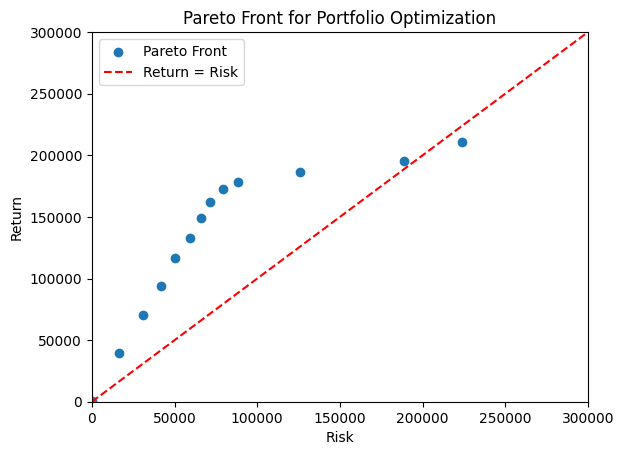

           Return           Risk
0   116287.866626   50335.819960
1      449.858093      81.006839
2   186574.109038  126123.214522
3    70144.375895   30756.171135
4   178741.851445   88372.325656
5   162347.180066   71720.092876
6   195281.624517  188658.786646
7   172981.405161   79592.540724
8   210970.739903  223914.412238
9   148902.428234   66007.333142
10  133220.105019   59342.363559
11   94256.884618   41758.297041
12   39650.022037   16363.561431
[[ 0  0  0  0  0  9  0 78  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  3  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  2  0  0 13  2 15  0  0  0  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  5  2 58  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 15  0  5  0  0  0  0  0  0  0  4  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0 13  0 75  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  5  0  0 10  0 26  0  9  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0

In [57]:
n_var = 24
params_list=[500, 100, 1.0, 1.0]  #pop_size, n_gen, x_rate, mutate_rate
result_df, opt_sols = main_opt(path, n_var, budget, params_list)
print(result_df)
print(opt_sols)